In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
import gc
import numpy as np # for efficient numerical computations
import pandas as pd # for data management
import matplotlib.pyplot as plt #to customize visualizations
import seaborn as sns #for easy/common visualizations
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Importing xgboost
from xgboost import XGBRegressor

import warnings
warnings.simplefilter("ignore")

#Importing other required libraries
import os
import re
import csv
import operator
import random
import datetime
from datetime import datetime
import warnings
color = sns.color_palette()
%matplotlib inline

random.seed(47)

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/'My Drive'

/content/drive/My Drive


In [0]:
train = pd.read_csv('data/zillow-prize-1/train_2016_v2.csv')
prop = pd.read_csv('data/zillow-prize-1/properties_2016.csv')
sample = pd.read_csv('data/zillow-prize-1/sample_submission.csv')

In [17]:
#set all columns as dtype float32
for c, dtype in zip(prop.columns, prop.dtypes):
	if dtype == np.float64:
		prop[c] = prop[c].astype(np.float32)

print('Creating training set ...')
#merge the training set adn the properties set
train = train.merge(prop, how='left', on='parcelid')


for c in train.dtypes[train.dtypes == 'float64'].index.values:
    train[c].fillna(train[c].median(), inplace = True)
    
#Imputing Null values with -1 and encoding Objects
for c in train.columns:
    train[c]=train[c].fillna(-1)
    if train[c].dtype == object:
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values))
        train[c] = lbl.transform(list(train[c].values))
         
#Dropping out outliers
train=train[ train.logerror > -0.417 ]
train=train[ train.logerror < 0.418 ]

#drop the useless features
x_train = train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = train['logerror']
print(x_train.shape, y_train.shape)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

# del df_train; gc.collect()


Creating training set ...
(88570, 55) (88570,)


In [13]:
# Printing out all the Variables
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
print (dtype_df)

#Testing various Regression models
allModels = {} # Dictionary of models and their respective losses

print("Running XGB Regression")
model = xgb.XGBRegressor()
predicted = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Linear Regression")
model = linear_model.LinearRegression()
predicted = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Bayesian Ridge Regression")
model = linear_model.BayesianRidge()
predicted = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Ridge Regression")
model = linear_model.Ridge()
predicted = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Lasso Regression")
model = linear_model.Lasso()
predicted = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Random Forest")
model = RandomForestRegressor()
predicted = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running KNN")
model = KNeighborsRegressor()
predicted = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Gradient Boosted Regressor")
model = GradientBoostingRegressor()
predicted = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Returning the best model")
sortedModels = sorted(allModels.items(), key=operator.itemgetter(1), reverse=True)
for model in sortedModels:
    print ('Model:', model[0])
    print ('Loss:', model[1])

                           Count Column Type
0                       parcelid       int64
1                       logerror     float64
2                transactiondate       int64
3          airconditioningtypeid     float32
4       architecturalstyletypeid     float32
5                   basementsqft     float32
6                    bathroomcnt     float32
7                     bedroomcnt     float32
8            buildingclasstypeid     float32
9          buildingqualitytypeid     float32
10             calculatedbathnbr     float32
11                    decktypeid     float32
12      finishedfloor1squarefeet     float32
13  calculatedfinishedsquarefeet     float32
14          finishedsquarefeet12     float32
15          finishedsquarefeet13     float32
16          finishedsquarefeet15     float32
17          finishedsquarefeet50     float32
18           finishedsquarefeet6     float32
19                          fips     float32
20                  fireplacecnt     float32
21        

In [8]:
#consider the best model and do hyperparameter tuning on the model using gridsearch
#scoring using negative mean absolute error
print("Running Parameter optimization on the Best Model")

params = {  
            "n_estimators": [10,100,200],
            "max_depth": [3,5,7],
            "min_child_weight": [1,3,5]
         }

xgb_model = XGBRegressor()  
xgb_cv    = GridSearchCV(xgb_model,params,verbose = 10,scoring='neg_mean_absolute_error')
xgb_cv.fit(x_train, y_train)  

print ('Best Score-', xgb_cv.best_score_)
print ('Best Parameters-', xgb_cv.best_params_)
print ('Best Estimator-', xgb_cv.best_estimator_)

Running Parameter optimization on the Best Model
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=3, min_child_weight=1, n_estimators=10 ................
[00:55:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, min_child_weight=1, n_estimators=10, score=-0.176, total=   1.4s
[CV] max_depth=3, min_child_weight=1, n_estimators=10 ................
[00:55:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=10, score=-0.182, total=   1.4s
[CV] max_depth=3, min_child_weight=1, n_estimators=10 ................
[00:55:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=10, score=-0.180, total=   1.4s
[CV] max_depth=3, min_child_weight=1, n_estimators=10 ................
[00:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=10, score=-0.177, total=   1.4s
[CV] max_depth=3, min_child_weight=1, n_estimators=10 ................
[00:55:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.5s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=10, score=-0.172, total=   1.4s
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............
[00:55:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.9s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=100, score=-0.055, total=  10.3s
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............
[00:56:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.2s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=100, score=-0.054, total=  10.5s
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............
[00:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   27.7s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=100, score=-0.052, total=  10.3s
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............
[00:56:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   38.0s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=100, score=-0.052, total=  10.3s
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............
[00:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   48.3s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=100, score=-0.052, total=  10.3s
[CV] max_depth=3, min_child_weight=1, n_estimators=200 ...............
[00:56:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=3, min_child_weight=1, n_estimators=200, score=-0.055, total=  20.5s
[CV] max_depth=3, min_child_weight=1, n_estimators=200 ...............
[00:57:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=3, min_child_weight=1, n_estimators=200, score=-0.054, total=  20.3s
[CV] max_depth=3, min_child_weight=1, n_estimators=200 ...............
[00:57:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=3, min_child_weight=1, n_estimators=200, score=-0.052, total=  20.2s
[CV] max_depth=3, min_child_weight=1, n_estimators=200 ...........

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 37.7min finished


Best Score- -0.05300594634838186
Best Parameters- {'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}
Best Estimator- XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


Cross validation again using best estimated parameters
[01:33:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:34:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:34:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:34:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:07] WARNING: /workspace/src/objective/regression_

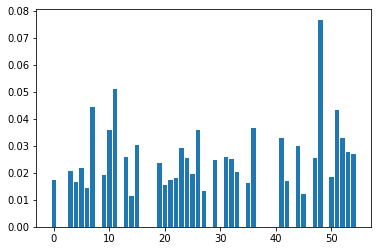

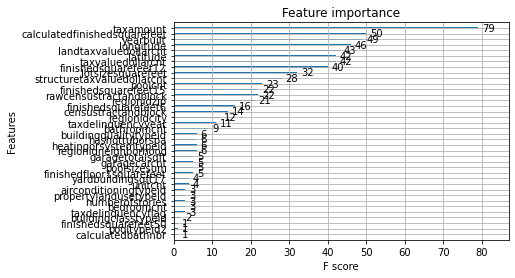

In [9]:
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from xgboost import plot_importance

print("Cross validation again using best estimated parameters")
clf = XGBRegressor(learning_rate =0.1,max_depth= 3,min_child_weight=3,n_estimators=100)
scores = cross_val_score(clf, x_train, y_train, cv=10,  scoring='neg_mean_absolute_error')
print("Printing Final Score")
print("MAE: %0.2f (+/- %0.2f)" % (abs(scores.mean()), scores.std()*2))

clf.fit(x_train, y_train)  
print("Printing Feature Importances")
print (clf.feature_importances_)
plt.bar(range(len(clf.feature_importances_)),clf.feature_importances_)
plt.show()

plot_importance(clf)
plt.show()

In [0]:
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')

x_test = df_test[train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

In [0]:
lol = clf.predict(x_test)

In [12]:
sub = pd.read_csv('data/zillow-prize-1/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = lol

print('Writing csv ...')
sub.to_csv('xgb_starter.csv', index=False, float_format='%.4f')

Writing csv ...


[(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1), -0.05296459113451378), (GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None,